In [1]:
import os, sys
project_home = "/Users/pitehrhurtado/Documents/OperationResearchs/clustering_and_discretization/src"
if project_home not in sys.path:
    sys.path = [project_home] + sys.path

In [2]:
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics

import logging

In [3]:
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

#### Configs

In [4]:
# pd.set_option("display.max_columns", None)
# pd.set_option("display.max_rows", None)

### A. Load data

In [5]:
raw = pd.read_csv("../data/base_customers_all_years_z7.csv")
raw['date'] = pd.to_datetime(raw['date'])
raw['year'] = raw['date'].dt.year
raw['month'] = raw['date'].dt.month

### B. Clean up

In [6]:
# remove negative demand
n_negative = len(raw[raw.demand <=0].index)
raw = raw[raw.demand > 0].reset_index(drop=True)
logger.info(f"Quantity of rows with negative demand: {n_negative}")

# Calcular los percentiles
percentil_1 = raw['demand'].quantile(0.01)
percentil_99_9 = raw['demand'].quantile(0.999)

# Filtrar los registros
n_rows = len(raw.index)
n_removed = len(raw[(raw['demand'] < percentil_1) | (raw['demand'] > percentil_99_9)])
raw = raw[(raw['demand'] >= percentil_1) & (raw['demand'] < percentil_99_9)].reset_index(drop=True)

logger.info(f"Quantity of rows removed: {n_removed} of total {n_rows}")

INFO:__main__:Quantity of rows with negative demand: 66430
INFO:__main__:Quantity of rows removed: 4484 of total 2702405


In [7]:
raw_grouped = raw.groupby(["year","month","cod_customer","lat","lon"]).agg(demand = ("demand","sum")).reset_index()
raw_grouped["demand"] = raw_grouped.apply(lambda x: x['demand']/25, axis=1)

### C. Transform

In [8]:
dates = list(raw['date'].unique())
logger.info(f"Number of day in data {len(dates)}")

INFO:__main__:Number of day in data 898


### D. Exploratory

####  Histogram with daily demand historic (3 years data)

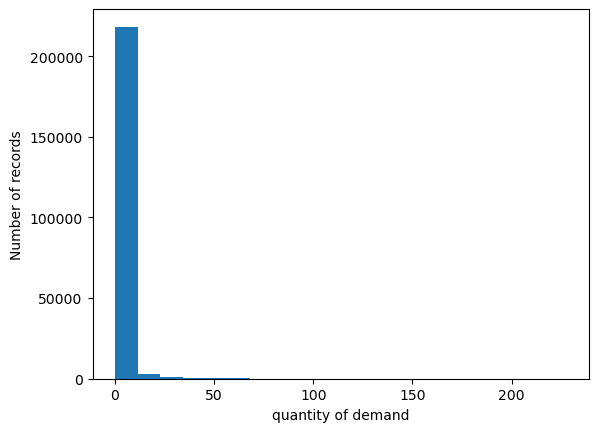

In [9]:
plt.hist(raw_grouped["demand"], bins=20)
plt.xlabel("quantity of demand")
plt.ylabel("Number of records")
plt.show()

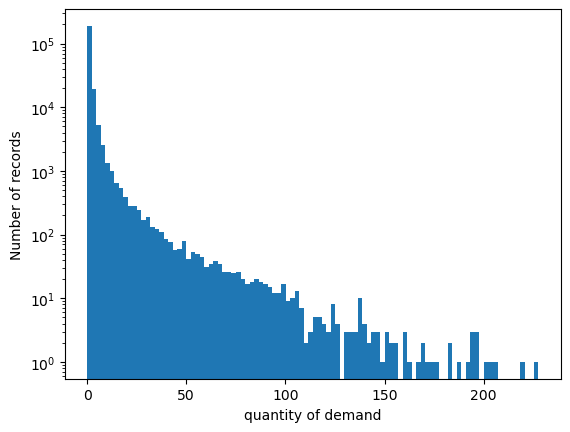

In [10]:
plt.hist(raw_grouped["demand"], bins=100)
plt.xlabel("quantity of demand")
plt.yscale("log")
plt.ylabel("Number of records")
plt.show()

# Playground v2

In [11]:
df_customers = raw_grouped.sort_values(by="demand", ascending=1)
n_customers = len(df_customers.index)

df_customers['demand_daily'] = df_customers['demand']
df_customers['demand_daily'] = df_customers['demand_daily'].astype("int64")
df_customers = df_customers[df_customers.demand_daily >0].sort_values(by="demand_daily",ascending=True).reset_index()

logger.info(f"N customers: {len(df_customers.index)}")

INFO:__main__:N customers: 77345


In [12]:
list_demand_daily = df_customers['demand_daily'].to_list()
logger.info(f"len: {len(list_demand_daily)}")

INFO:__main__:len: 77345


## A. Compute number of required layers

This approach consider the Kmeans algorithm to compute the ideal number of layer required, we used two metrics to determinate what is the best number of layers

/Users/pitehrhurtado/mambaforge/envs/redesign_network/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/pitehrhurtado/mambaforge/envs/redesign_network/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/pitehrhurtado/mambaforge/envs/redesign_network/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/pitehrhurtado/mambaforge/envs/redesign_network/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change 

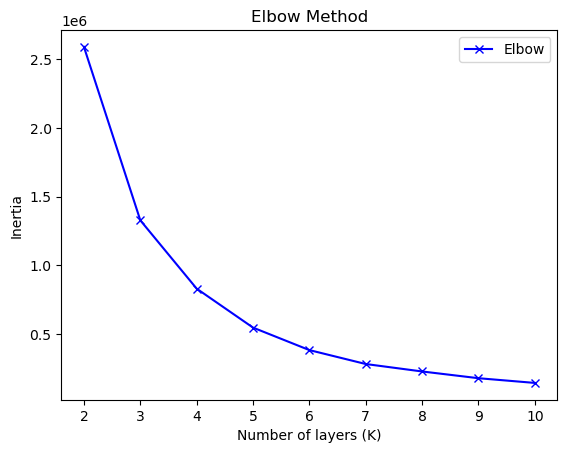

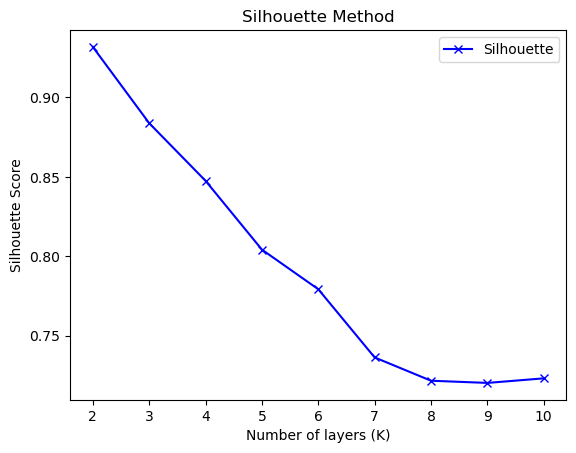

In [13]:
x = list_demand_daily

# set seed
SEED = 100

k_values = range(2, 11)

# score: elbow
inertia_values = []
# score: silohuette
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=SEED)
    
    kmeans.fit(np.array(x).reshape(-1, 1))
    inertia_values.append(kmeans.inertia_)
    
    labels = kmeans.labels_
    silhouette_scores.append(metrics.silhouette_score(np.array(x).reshape(-1, 1), labels))

# Graficar la curva de la suma de las distancias cuadradas en función de K
plt.plot(k_values, inertia_values, 'bx-', label='Elbow')
plt.xlabel('Number of layers (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.legend()
plt.show()

# Graficar la curva de los puntajes de silueta en función de K
plt.plot(k_values, silhouette_scores, 'bx-', label='Silhouette')
plt.xlabel('Number of layers (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method')
plt.legend()
plt.show()

In [14]:
labels_by_k = []
for k_selected in [2,3]:
    logger.info(f"[Layers] Number of layers selected is {k_selected} \n")
    kmeans = KMeans(n_clusters=k_selected, random_state=SEED)
    kmeans.fit(np.array(x).reshape(-1, 1))

    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_

    for k in range(k_selected):
        cluster_data = np.array(x)[labels == k]
        #print(f"Cluster {k+1}: {cluster_data}")
        std_dev = np.std(cluster_data)
        mean_ = np.mean(cluster_data)
        logger.info("Layer {0}: Standart Desviation = {1} - Mean = {2}".format(k+1, std_dev, mean_))
        perc = len(cluster_data) * 100 / len(x)
        logger.info(f"Layer {k+1}: number of customers {len(cluster_data)} - {perc:.2f}% of total \n")
    logger.info(f"Total customers: {len(x)}")
    labels_by_k.append(labels)

INFO:__main__:[Layers] Number of layers selected is 2 

/Users/pitehrhurtado/mambaforge/envs/redesign_network/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
INFO:__main__:Layer 1: Standart Desviation = 4.114142689731969 - Mean = 3.0253094548327626
INFO:__main__:Layer 1: number of customers 75940 - 98.18% of total 

INFO:__main__:Layer 2: Standart Desviation = 30.471826779864802 - Mean = 61.11387900355872
INFO:__main__:Layer 2: number of customers 1405 - 1.82% of total 

INFO:__main__:Total customers: 77345
INFO:__main__:[Layers] Number of layers selected is 3 

/Users/pitehrhurtado/mambaforge/envs/redesign_network/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warnin

### In this case I decided to use k = 3, i.e. the number of layer will be 3

In [15]:
df_customers["layer"] = labels_by_k[1] # k = 3

## B. Generate Squared - Grid

In [16]:
from app.grids.grid import GridCreator

In [17]:
grid_creator = GridCreator(df=df_customers,km_distance=1)

In [18]:
df_output = grid_creator.run()
grid_df = grid_creator.geo.copy()

INFO:app.grids.grid:[GRID-CREATOR] number of pixels: 304
/var/folders/x6/7z03llzd6tv506jmg9k6xsxc0000gn/T/ipykernel_34410/2454996680.py:1: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  df_output = grid_creator.run()


## C. Plot Grid

In [19]:
from app.plots.plot_grid import Plot_Grid

In [20]:
plotter = Plot_Grid(
    grid_geo = grid_df,
    df = df_output,
)

INFO:app.plots.plot_grid:[Plotting Grid] Total pixels: 304 

INFO:app.plots.plot_grid:
[Plotting Grid] Number of pixels with customers: 123 
[Plotting Grid] Number of pixels without customers: 181 

/Users/pitehrhurtado/mambaforge/envs/redesign_network/lib/python3.10/site-packages/geopandas/plotting.py:658: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


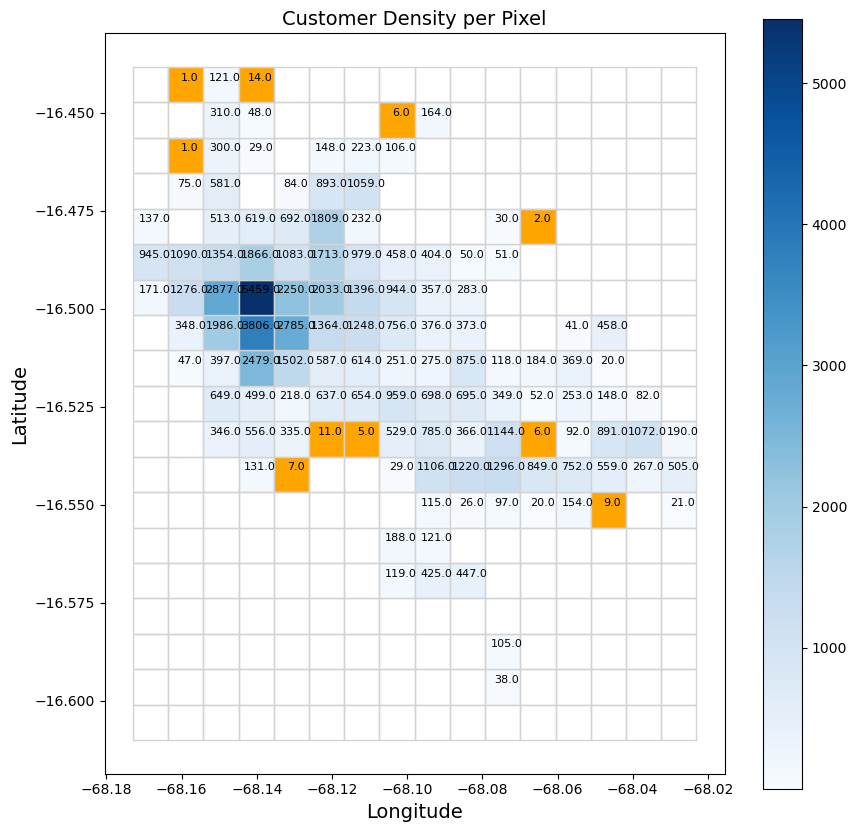

In [21]:
plotter.plot_density_customer()

INFO:app.plots.plot_grid:[Plotting Grid] Total pixels: 304 



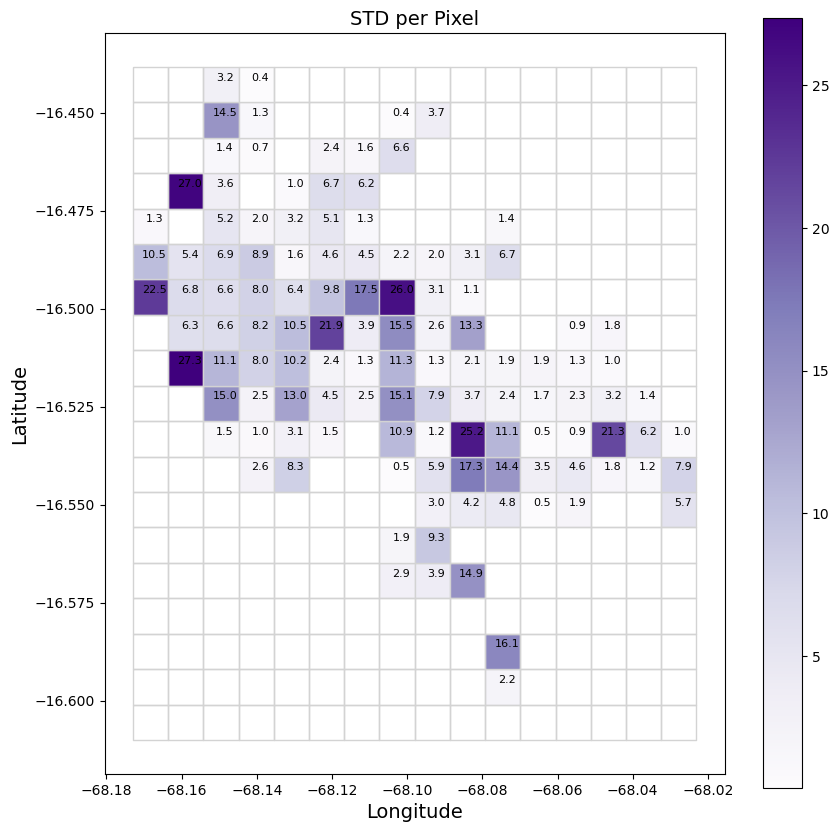

In [22]:
plotter.plot_grid_by_metric(metric="std")

## D. Plot Grid by LAYER

##### Consideration
color orange is used when pixel have number of customer least than 20

In [23]:
def plot_by_layer(layer: int, df: pd.DataFrame, geo: gpd.GeoDataFrame) -> None:
    """
    """
    df_filtered = df[df.layer == layer].reset_index(drop=True)
    plotter = Plot_Grid(
        grid_geo = geo,
        df = df_filtered,
    )
    logger.info(f"[PLOT-BY-LAYER] Layer {layer} is plotting")
    # n customer per pixel
    plotter.plot_density_customer()
    
    # std per pixel
    plotter.plot_grid_by_metric(metric="std")
    
    # mean per pixel
    plotter.plot_grid_by_metric(metric="mean")
    

INFO:__main__:[PLOT-BY-LAYER] Layer 0 is plotting
INFO:app.plots.plot_grid:[Plotting Grid] Total pixels: 304 

INFO:app.plots.plot_grid:
[Plotting Grid] Number of pixels with customers: 123 
[Plotting Grid] Number of pixels without customers: 181 

/Users/pitehrhurtado/mambaforge/envs/redesign_network/lib/python3.10/site-packages/geopandas/plotting.py:658: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


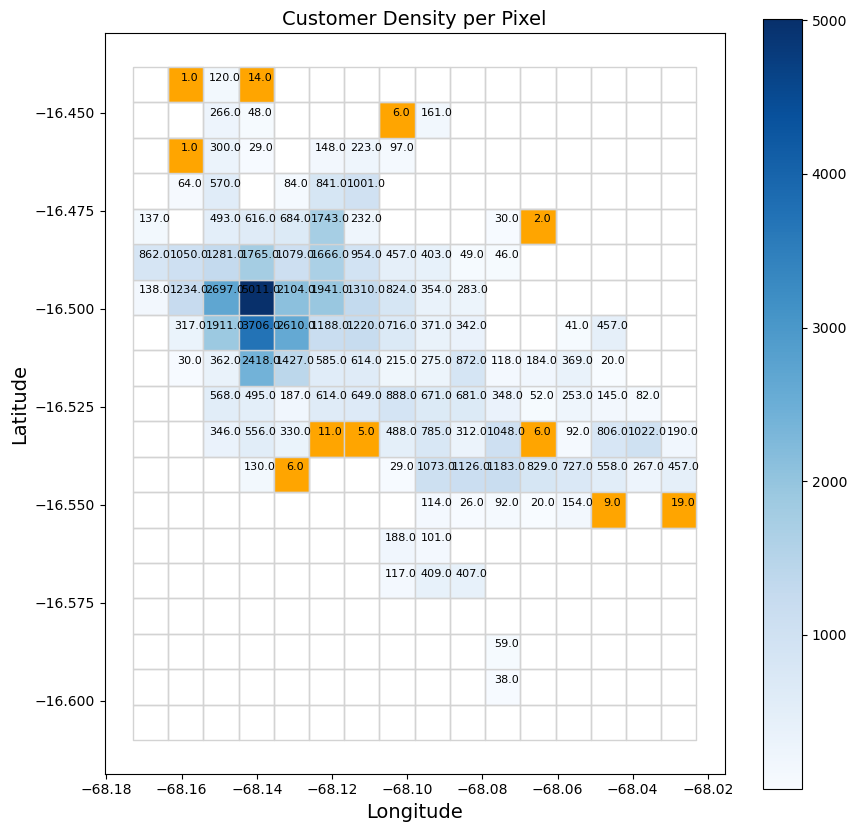

INFO:app.plots.plot_grid:[Plotting Grid] Total pixels: 304 



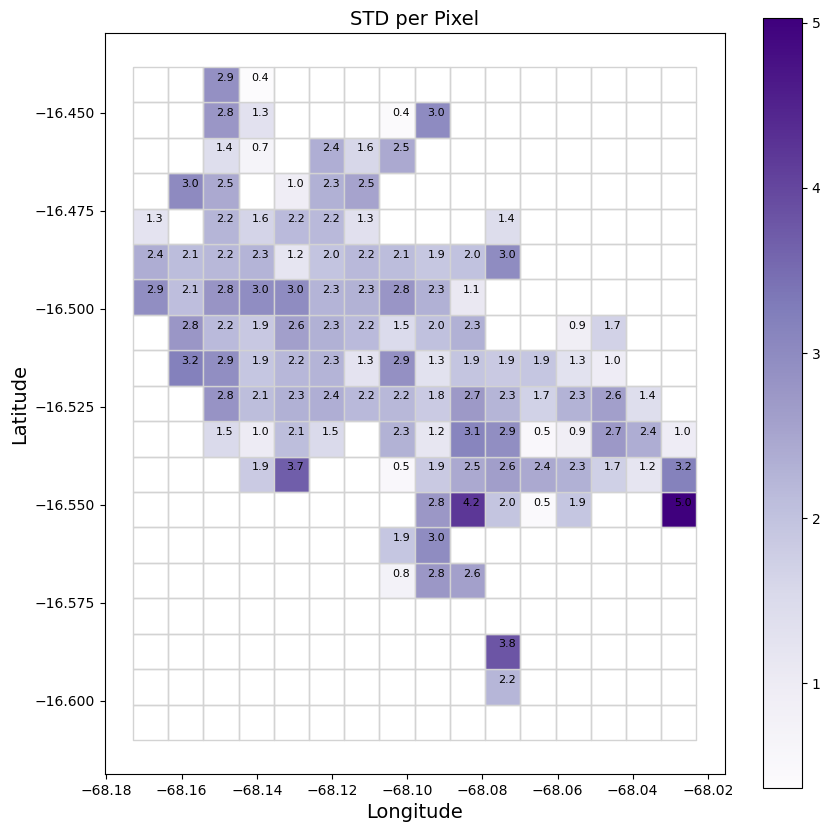

INFO:app.plots.plot_grid:[Plotting Grid] Total pixels: 304 



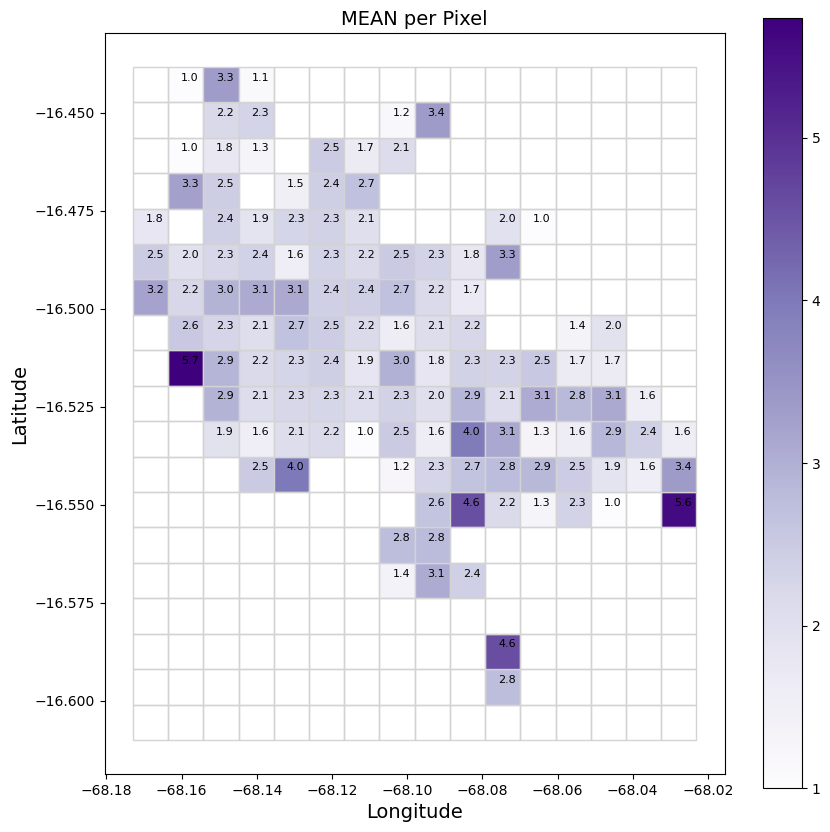

In [24]:
# LAYER 0
plot_by_layer(
    layer=0,
    df=df_output,
    geo=grid_df,
)

INFO:__main__:[PLOT-BY-LAYER] Layer 1 is plotting
INFO:app.plots.plot_grid:[Plotting Grid] Total pixels: 304 

INFO:app.plots.plot_grid:
[Plotting Grid] Number of pixels with customers: 42 
[Plotting Grid] Number of pixels without customers: 262 

/Users/pitehrhurtado/mambaforge/envs/redesign_network/lib/python3.10/site-packages/geopandas/plotting.py:658: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


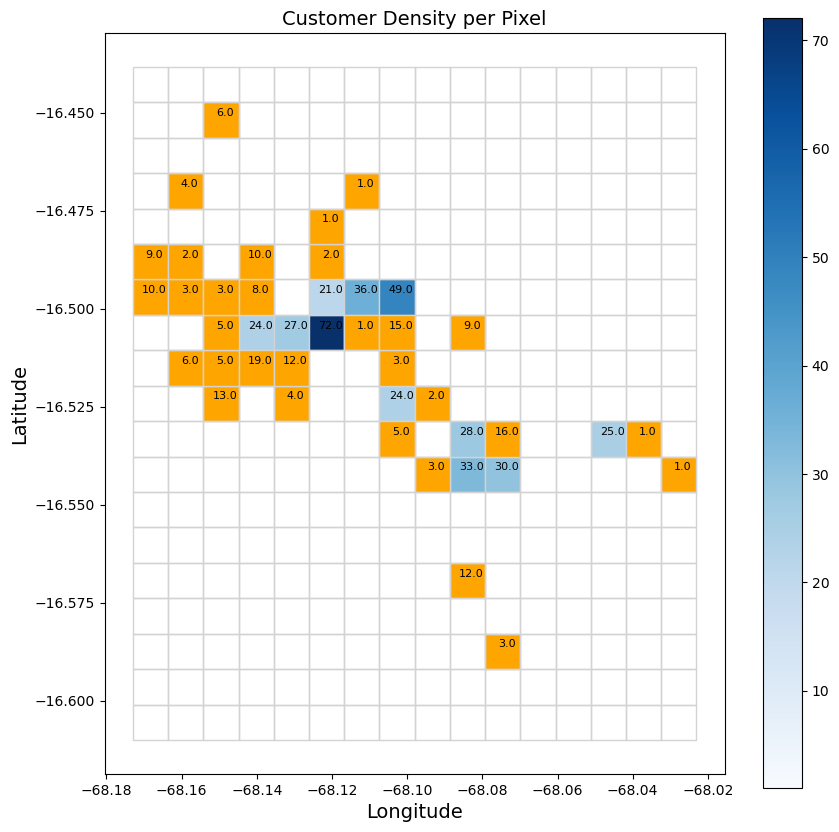

INFO:app.plots.plot_grid:[Plotting Grid] Total pixels: 304 



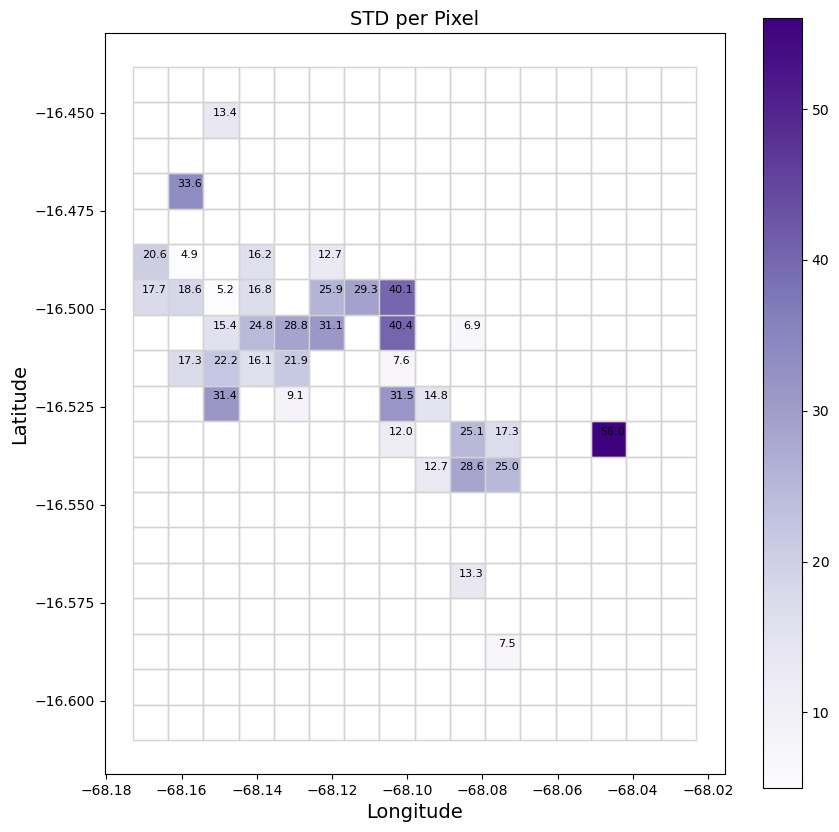

INFO:app.plots.plot_grid:[Plotting Grid] Total pixels: 304 



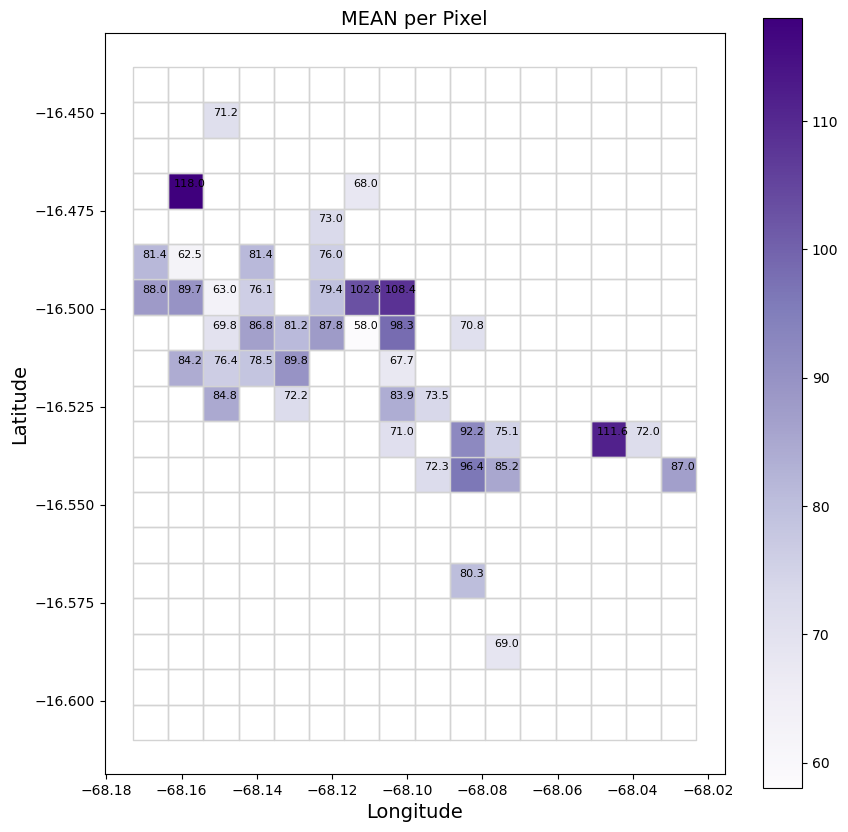

In [25]:
# LAYER 1
plot_by_layer(
    layer=1,
    df=df_output,
    geo=grid_df,
)

INFO:__main__:[PLOT-BY-LAYER] Layer 2 is plotting
INFO:app.plots.plot_grid:[Plotting Grid] Total pixels: 304 

INFO:app.plots.plot_grid:
[Plotting Grid] Number of pixels with customers: 82 
[Plotting Grid] Number of pixels without customers: 222 

/Users/pitehrhurtado/mambaforge/envs/redesign_network/lib/python3.10/site-packages/geopandas/plotting.py:658: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


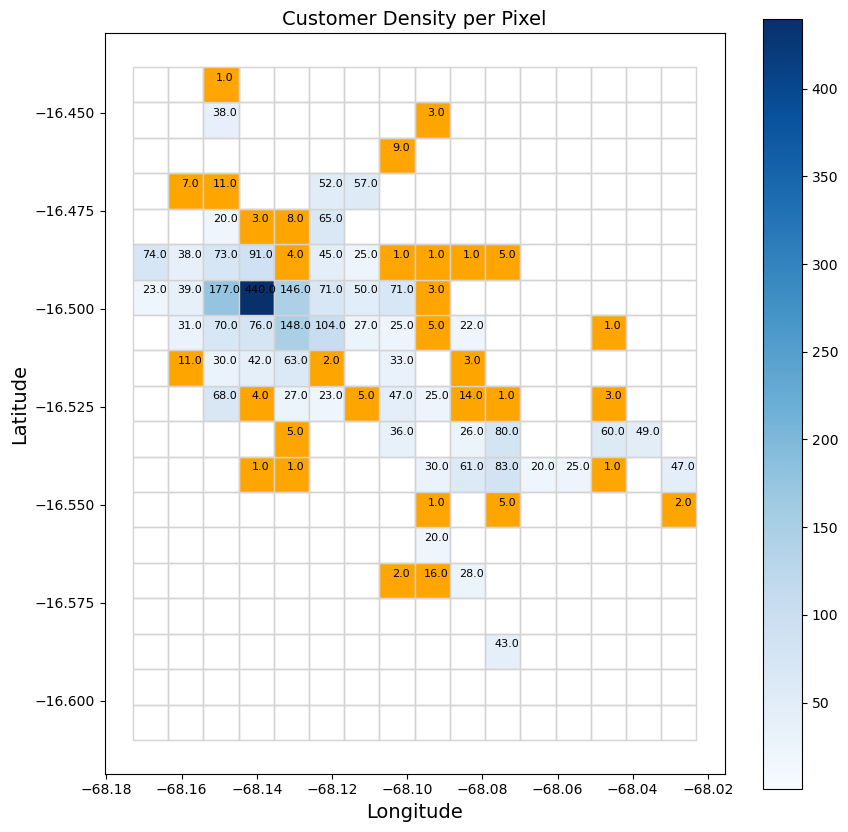

INFO:app.plots.plot_grid:[Plotting Grid] Total pixels: 304 



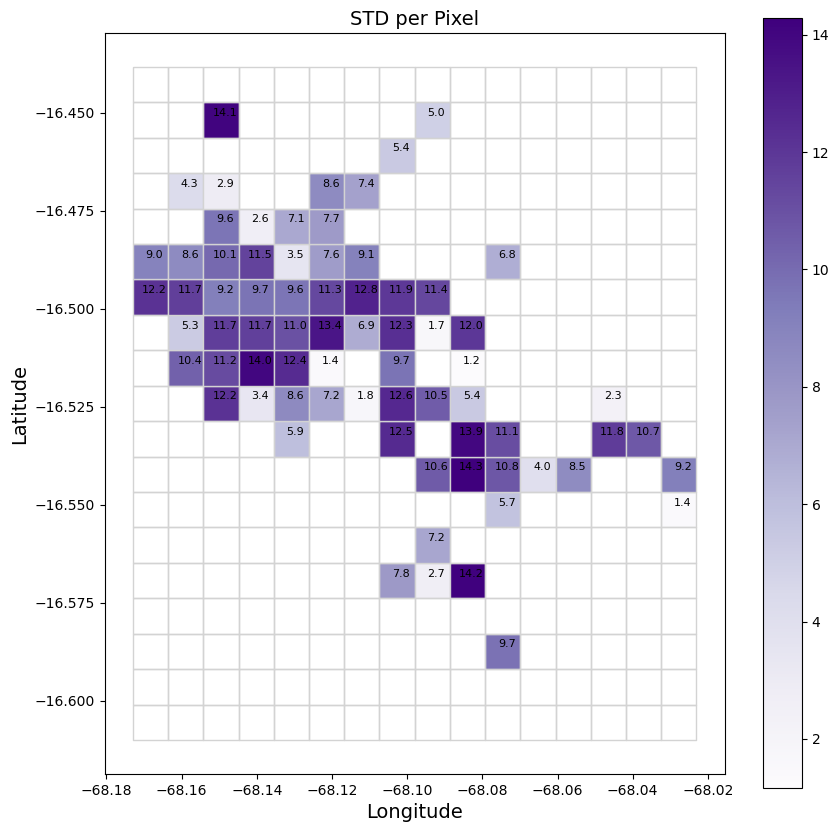

INFO:app.plots.plot_grid:[Plotting Grid] Total pixels: 304 



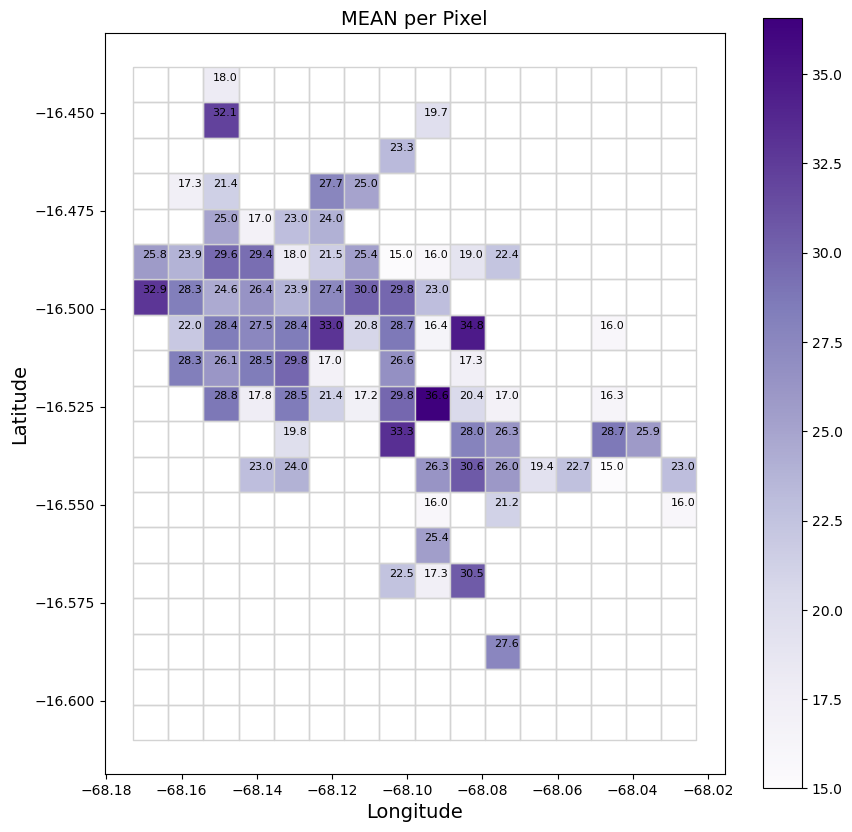

In [26]:
# LAYER 2
plot_by_layer(
    layer=2,
    df=df_output,
    geo=grid_df,
)

In [27]:
grid_df.to_file("../data/geodf.geojson", driver='GeoJSON')
